In [27]:
import torch
import pyro
import json
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
import numpy as np
import seaborn as sns

from ESN import esnet
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Time-series forecasting

## Train ESN

Tr: 4882, Val: 1047, Te: 1047
train_embedding shape: (4882, 20)
Test MSE 0.192


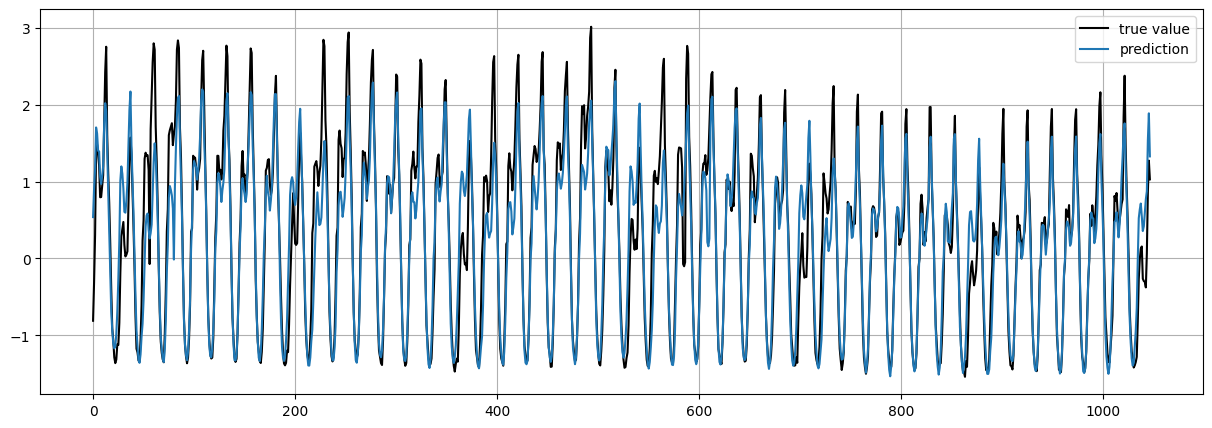

In [2]:
forecast_horizon = 24 

mat = loadmat('dataset/TS_Acea.mat')  # load mat-file
ACEA_data = mat['X'] # original resolution (1 = 10 mins)
ACEA_data = ACEA_data[::6] 
ACEA_data = ACEA_data[:7000] 

X = ACEA_data[:-forecast_horizon]
Y = ACEA_data[forecast_horizon:]

# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

Xtr, Ytr, Xval, Yval, Xte, Yte = esnet.generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)
print("Tr: {:d}, Val: {:d}, Te: {:d}".format(Xtr.shape[0], Xval.shape[0], Xte.shape[0]))

# Train and compute predictions
Yte_pred, _, _, train_embedding, _, val_embedding, _, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)
print("train_embedding shape:", train_embedding.shape)
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.plot(Yte_pred, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

## Bayesian regression

In [3]:
n_dims = train_embedding.shape[1]
dtype = 'float32'
train_embedding = train_embedding.astype(dtype)
train_embedding = torch.from_numpy(train_embedding).to(device)
# val_embedding = val_embedding.astype(dtype)
test_embedding = test_embedding.astype(dtype)
test_embedding = torch.from_numpy(test_embedding).to(device)
Ytr = Ytr.astype(dtype).squeeze()
Ytr = torch.from_numpy(Ytr).to(device)

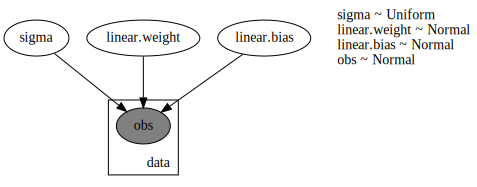

In [4]:

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features).to(device)
        self.linear.weight = PyroSample(dist.Normal(torch.tensor(0., device=device), torch.tensor(10., device=device)).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(torch.tensor(0., device=device), torch.tensor(10., device=device)).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.)).to(device)
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0], device=device):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

model = BayesianRegression(n_dims, 1)
pyro.render_model(model, model_args=(train_embedding, Ytr), render_distributions=True)

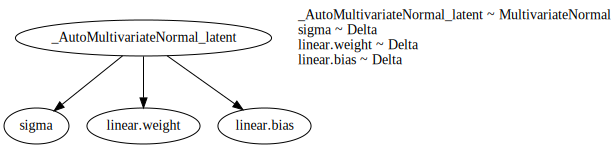

In [5]:
# To enforce all the parameters in the guide on the GPU, since we use an autoguide
torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

In [6]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).get_device())

AutoMultivariateNormal.loc 0
AutoMultivariateNormal.scale 0
AutoMultivariateNormal.scale_tril 0


Print starting guide's parameters:

In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoMultivariateNormal.loc [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AutoMultivariateNormal.scale [0.09999999 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999
 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999
 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999
 0.09999999 0.09999999 0.09999999 0.09999999]
AutoMultivariateNormal.scale_tril [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [8]:
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 1500

# pyro.clear_param_store() # why do we need to clear the param store first?
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(train_embedding, Ytr)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / Ytr.shape[0]))

guide.requires_grad_(False)

[iteration 0001] loss: 2.6176
[iteration 0101] loss: 0.6290
[iteration 0201] loss: 0.6128
[iteration 0301] loss: 0.6154
[iteration 0401] loss: 0.6128
[iteration 0501] loss: 0.6099
[iteration 0601] loss: 0.6119
[iteration 0701] loss: 0.6108
[iteration 0801] loss: 0.6122
[iteration 0901] loss: 0.6105
[iteration 1001] loss: 0.6137
[iteration 1101] loss: 0.6108
[iteration 1201] loss: 0.6108
[iteration 1301] loss: 0.6108
[iteration 1401] loss: 0.6107


AutoMultivariateNormal()

Check that the guide's parameters changed:

In [9]:

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoMultivariateNormal.loc Parameter containing:
tensor([-3.0878,  0.2966, -0.3376, -0.1705,  0.2143,  0.0413, -0.1928,  0.0869,
         0.1095, -0.0938, -0.1375,  0.3042,  0.3907,  0.5881,  1.1284, -0.0968,
        -0.5992, -1.4832,  0.2541, -0.5870,  0.6530,  0.0148])
AutoMultivariateNormal.scale tensor([0.0123, 0.0027, 0.0040, 0.0088, 0.0148, 0.0165, 0.0263, 0.0259, 0.0334,
        0.0373, 0.0421, 0.0513, 0.0599, 0.0678, 0.0665, 0.0897, 0.0936, 0.1058,
        0.1226, 0.1231, 0.1431, 0.0051])
AutoMultivariateNormal.scale_tril tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.0388e-02,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+0

Print 5 sampled values of the regression parameters

In [11]:
# samples = {}
sigmas = []
biases = []
weights = []
for n in range(5):
    sample = guide()
    sigmas.append(sample["sigma"].cpu().numpy())
    biases.append(sample["linear.bias"].squeeze().cpu().numpy())
    weights.append(sample["linear.weight"].squeeze().cpu())

weights = torch.stack(weights).T.cpu()

samples = {"sigma" : sigmas, "bias" : biases}

for i in range(weights.shape[0]):
    samples[f"w_{i}"] = weights[i].tolist()

In [12]:
regr_df = pd.DataFrame(samples)
regr_df.head()

,sigma,bias,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,...,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19
0,0.4393554,0.016756738,0.294288,-0.337959,-0.163440,0.209859,0.026286,-0.207688,0.037193,0.061275,...,0.355088,0.476264,0.776525,0.973983,0.066914,-0.688053,-1.454485,0.179895,-0.764678,1.112292
1,0.4344445,0.004083408,0.294591,-0.344228,-0.173666,0.212271,0.051448,-0.236049,0.087292,0.111699,...,0.338152,0.406751,0.643208,1.115319,-0.078707,-0.602925,-1.567111,0.222218,-0.789497,0.828981
2,0.43989837,0.028898783,0.297356,-0.340539,-0.182251,0.206514,0.019745,-0.230932,0.060264,0.076699,...,0.250843,0.355049,0.619124,0.940791,-0.110039,-0.532401,-1.391693,0.280899,-0.839307,0.835020
3,0.43694946,0.009725232,0.297054,-0.341842,-0.156043,0.211483,0.025687,-0.187038,0.093071,0.141394,...,0.313708,0.423631,0.501361,1.174424,-0.112418,-0.720857,-1.397489,0.454053,-0.641253,0.907997
4,0.43548167,0.022285566,0.300593,-0.334460,-0.169080,0.205138,0.038814,-0.209776,0.094340,0.155199,...,0.266177,0.313306,0.548437,1.138317,-0.082687,-0.621817,-1.539834,0.472186,-0.614573,0.756280


Make predictions

In [13]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)(x=test_embedding, y=None)

In [ ]:
# not used for now
pred_df = pd.DataFrame(predictive["obs"])
pred_stats = pred_df.describe(percentiles=[0.05,0.5,0.95]).transpose()
pred_stats = pred_stats[["mean", "std", "5%", "95%"]]

In [14]:
def compute_coverage_len(y_test, y_lower, y_upper, verbose=False):
    """ 
    Compute average coverage and length of prediction intervals
    """
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    avg_length = np.mean(abs(y_upper - y_lower))
    avg_length = avg_length/(y_test.max()-y_test.min())
    if verbose==True:
        print("PI coverage: {:.2f}, PI avg. length: {:.2f}".format(coverage, avg_length))
    return coverage, avg_length

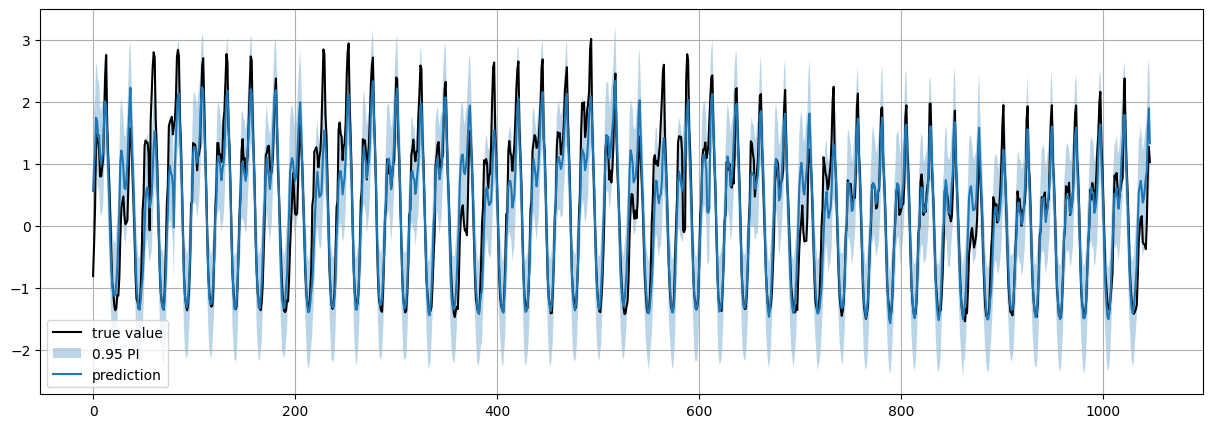

PI coverage: 0.91, PI avg. length: 0.37


In [16]:
# draw and compute the 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive["obs"].cpu().numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.fill_between(np.arange(predictive["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

_, _ = compute_coverage_len(Yte.squeeze(), q_low, q_hi, verbose=True)

The output is not calibrated.

## MCMC

In [17]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=1000, num_chains=1)
mcmc.run(train_embedding, Ytr)
mcmc.summary(prob=0.95)

Sample: 100%|██████████| 4000/4000 [03:38, 18.27it/s, step size=5.04e-01, acc. prob=0.897]



                         mean       std    median      2.5%     97.5%     n_eff     r_hat
     linear.bias[0]      0.00      0.01      0.00     -0.01      0.01   7173.01      1.00
 linear.weight[0,0]      0.30      0.00      0.30      0.29      0.30   4847.63      1.00
 linear.weight[0,1]     -0.33      0.00     -0.33     -0.34     -0.32   7448.09      1.00
 linear.weight[0,2]     -0.17      0.01     -0.17     -0.18     -0.15   5246.65      1.00
 linear.weight[0,3]      0.22      0.01      0.22      0.20      0.24   5391.90      1.00
 linear.weight[0,4]      0.06      0.02      0.06      0.02      0.09   5192.87      1.00
 linear.weight[0,5]     -0.19      0.03     -0.19     -0.24     -0.14   5853.07      1.00
 linear.weight[0,6]      0.07      0.03      0.07      0.02      0.13   4381.82      1.00
 linear.weight[0,7]      0.11      0.03      0.11      0.04      0.17   5690.93      1.00
 linear.weight[0,8]     -0.07      0.04     -0.07     -0.15      0.02   6038.18      1.00
 linear.w

The last two columns are:
- the `effective_sample_size()`
- and the `split_gelman_rubin()`

In [23]:

hmc_samples_ = {k: v.detach().squeeze().cpu().numpy() for k, v in mcmc.get_samples().items()}

# Split  the weights
hmc_samples = {}
for k, v in hmc_samples_.items():
    if k == "sigma" or k == "linear.bias":
        hmc_samples[k] = v
    elif k == "linear.weight":
        for i in range(v.shape[1]):
            hmc_samples[f"w_{i}"] = v[:,i]

chains_df = pd.DataFrame(hmc_samples)
chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % 3000,
        chain_id=lambda x: (x['sample_id'] / 3000).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str))

Text(0.5, 1.03, 'Posterior Samples per Chain')

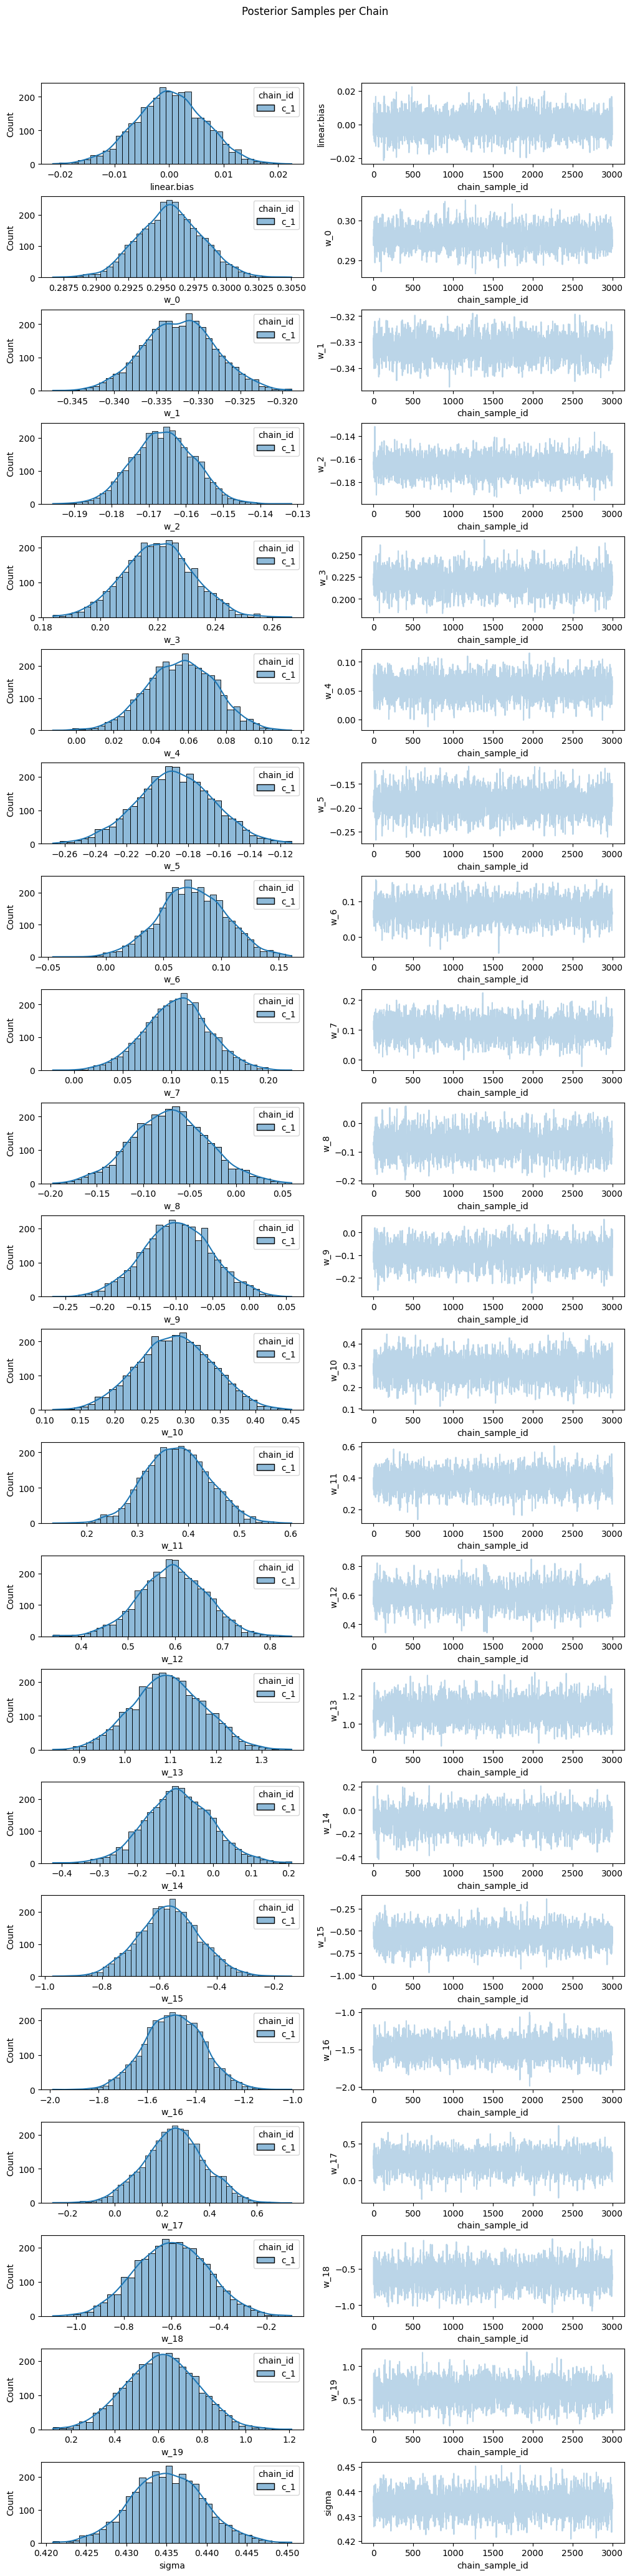

In [32]:
fig, axes = plt.subplots(nrows=len(hmc_samples), ncols=2, figsize=(10, 40), constrained_layout=True)

for i, param in enumerate(hmc_samples.keys()):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)